In [11]:
import os,sys,itertools,functools,copy
from functools import partial

import numpy as onp
import scipy as osp
import jax
import jax.numpy as np
import jax.scipy as sp
import jax.example_libraries.optimizers
np.set_printoptions(linewidth=1000,formatter={**{dtype: (lambda x: format(x, '0.2e')) for dtype in ['float','float64',np.float64,np.float32]}})
jax.config.update('jax_platform_name','cpu')
jax.config.update('jax_enable_x64', True)

import matplotlib
import matplotlib.pyplot as plt

In [198]:
# Fideltity distance measure (to be minimized)
@jax.jit
def distance(a,b):
    n = a.shape[0]
#     return 1-np.abs(np.trace(a.dot(b.conj().T)))/n
    return np.linalg.norm(a-b,axis=None,ord=2)/n

# Tensor product of tensor of arrays of shape (k,n,n)
def tensorprod(x):
    out = x[0]
    for i in range(1,len(x)):
        out = np.kron(out,x[i])
    return out

# Sigmoid function for constraints
@jax.jit
def sigmoid(a,scale=1e6):
    return np.exp(-np.logaddexp(0, -scale*a))

# Matrix exponential of data with parameters (using Euler identity)
@jax.jit
def expm(x,data,identity):
    def func(x,data,identity,out):
        return out.dot(np.cosh(x)*identity + np.sinh(x)*data)
    p = x.shape[0]
    n = data.shape[0]
    
    out = identity
    return jax.lax.fori_loop(0,p,lambda i,out: func(x[i],data[i%n],identity,out),out)

# Initialize x,data,identity,parameters,target 
# for n qubits, m time steps, p trotterization, q variable parameters per time step
def init(n,m,p,q):
    
    # Basis of single qubit operators
    basis = {
        'x':np.array([[0,1],[1,0]],dtype='complex'),
        'y':np.array([[0,-1j],[1j,0]],dtype='complex'),
        'z':np.array([[1,0],[0,-1]],dtype='complex'),
        'i':np.array([[1,0],[0,1]],dtype='complex'),
    }
    
    # Get hamiltonian term string names (to be trotterized)
    data = [
        *[['x' if k in [i] else 'i' for  k in range(n)] for i in range(n)],
        *[['y' if k in [i] else 'i' for  k in range(n)] for i in range(n)],
        *[['z' if k in [i] else 'i' for  k in range(n)] for i in range(n)],
        *[['z' if k in [i,j] else 'i' for  k in range(n)] for i in range(n) for j in range(n) if i<j],
    ]
    
    # Get identity operator
    identity = ['i' for i in range(n)]

    # Get data operators from basis strings
    data = np.array([tensorprod([basis[i] for i in j]) for j in data])
    
    # Perform p order Trotterization
    data = np.array([v for u in [data[::i] for i in [1,-1,1,-1][:p]] for v in u])
    
    # Get identity element operator
    identity = tensorprod([basis[i] for i in identity])
    
    # Get constant parameters
    constants = np.array(onp.random.rand(m,n+(n*(n-1))//2))
    
    # Get target unitary
    if n == 3:
        target = np.array([
           [1,0,0,0,0,0,0,0],
           [0,1,0,0,0,0,0,0],
           [0,0,1,0,0,0,0,0],
           [0,0,0,1,0,0,0,0],
           [0,0,0,0,1,0,0,0],
           [0,0,0,0,0,1,0,0],
           [0,0,0,0,0,0,0,1],
           [0,0,0,0,0,0,1,0]])
    else:
      target = np.array(onp.random.rand(2**n,2**n))
      target = sp.linalg.expm(-1j*(target+target.conj().T)/2)

    # Get initial variable parameters (with boundary conditions)
    variables = np.array(onp.random.rand(m,q))
    
    variables = variables.at[0,:].set(0)
    variables = variables.at[-1,:].set(0)
    
    variables = variables.ravel()
        
    return variables,data,identity,constants,target

# Settings
onp.random.seed(1546) # random seed
n = 3 # number of qubits
m = 500 # number of time steps
p = 2 # order of trotterization
q = 2*n # number of variables parameters (2 for single amplitude + phase for all qubits, 2*n for individual amplitude + phase for each qubit)
lmbda = 1e-10 # penalty lagrange multiplier
t = 30 # number of optimization iterations
alpha = 1e-1 # initial learning rate

# Initialize (m,q) parameters x, data of (2n + n + n(n-1)/2, 2**n, 2**n) x + y + z + zz hamiltonian operators
# x + y are controlled by variable amplitude + phase, z + zz are controlled by fixed parameters (random in this case)
# identity is identity operator of shape (2**n,2**n)
# parameters are fixed parameters (for z + zz) of shape (m, n + n(n-1)/2)
# target is target unitary (i.e) 3 qubit toffoli)

variables,data,identity,constants,target = init(n,m,p,q)

# Parameterized unitary for parameters of flattened x of size (m*q)
def model(variables,n=n,m=m,p=p,q=q,data=data,identity=identity,constants=constants,target=target):
    
    # Reshape variables into time + space dimensions
    variables = variables.reshape(m,q)
    
    shape = (m,len(data)//p)

    # Fill all parameters with variables + constants parameters
    parameters = np.zeros(shape,dtype='complex')
    
    parameters = parameters.at[:,0*n:1*n].set(variables[:,0::2]*np.cos(2*np.pi*(variables[:,1::2]))) # x parameters
    parameters = parameters.at[:,1*n:2*n].set(variables[:,0::2]*np.sin(2*np.pi*(variables[:,1::2]))) # y parameters
    parameters = parameters.at[:,2*n:].set(constants) # z + zz parameters
    
    # Do p order trotterization (repetition) of parameters
    parameters = np.array([v for u in [parameters.T[::i] for i in [1,-1,1,-1][:p]] for v in u]).T
    
    # Flatten parameters
    parameters = parameters.ravel()
    
    # Get matrix exponential of hamiltonian based on data (with time step 1/m)
    U = expm(-1j*parameters/m,data,identity)
    
    return U

# Loss function (fidelity + constraints)
def func(variables,n=n,m=m,p=p,q=q,data=data,identity=identity,constants=constants,target=target,lmbda=lmbda):
    
    # Get parameterized unitary
    U = model(variables,n=n,m=m,p=p,q=q,data=data,identity=identity,constants=constants,target=target)
    
    # Get constraints on parameters being within bounds, and boundary conditions of being 0 at time=0,m-1
    constraints = lmbda*(
        (sigmoid(0-variables) + 
        sigmoid(variables-1)).sum() + 
        (sigmoid(-variables[:q]) + 
        sigmoid(-variables[-q:])).sum()
        )
    fidelity = distance(U,target) 
    
    return fidelity + constraints

# Perform gradient descent (conjugate gradient)
grad = jax.grad(func)

iterations = []
values = []
parameters = [variables.copy()]

f = func(variables) # function value
g = grad(variables) # gradient value
s = -grad(variables) # search direction

for i in range(t):
    
    # Get values
    _f = f.copy()
    _g = g.copy()
    _s = s.copy()
    
    # Get search learning rate
    alpha = osp.optimize.line_search(func,grad,variables,_s)[0]
    if alpha is None:
        alpha = 1e-4
    
    # Update variables with search direction
    variables += alpha*_s
        
    # Get updated values
    f = func(variables)
    g = grad(variables)
    
    # Get new search direction
#     s = -g
    
    beta = (g.dot(g))/(_g.dot(_g))        
    s = -g + beta*_s
   
    
    # Update tracked values
    iterations.append(i+1)       
    values.append(1-distance(model(variables),target))
    parameters.append(variables.copy())
    
    # Print tracked values and model output
    print('i = %d, f(x) = %0.5f, alpha = %0.3e, beta = %0.3e\nU(x)'%(i,values[-1],alpha,beta))
    print(model(variables).round(3))
    print()


/home/matt/miniconda3/envs/mkl/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


i = 0, f(x) = 0.77963, alpha = 1.000e-04, beta = 1.000e+00
U(x)
[[ 0.97 +0.229j  0.01 +0.051j  0.052-0.007j  0.002+0.j     0.047-0.002j  0.002+0.001j  0.002-0.001j  0.   +0.j   ]
 [-0.022+0.047j  0.997+0.024j -0.001+0.001j  0.038-0.02j   0.001+0.j    -0.007+0.002j  0.   +0.j     0.   +0.001j]
 [-0.048-0.02j  -0.001-0.003j  0.997+0.031j  0.053+0.005j  0.   -0.001j  0.   +0.j    -0.004+0.007j  0.002+0.j   ]
 [ 0.   +0.003j  0.033-0.027j  0.017-0.051j -0.374+0.923j  0.   +0.j     0.002-0.002j  0.001-0.001j  0.014+0.054j]
 [-0.046-0.01j  -0.001-0.002j -0.002+0.j     0.   +0.j     0.994-0.066j  0.053+0.004j  0.033-0.024j  0.   -0.002j]
 [-0.001-0.001j -0.006+0.005j  0.   +0.j     0.   +0.001j  0.022-0.048j -0.552+0.831j  0.   -0.002j  0.019+0.044j]
 [ 0.001+0.j     0.   +0.j    -0.008+0.001j -0.002+0.001j  0.033-0.025j  0.   -0.001j -0.36 +0.932j  0.031+0.001j]
 [ 0.   +0.j     0.001+0.003j  0.001+0.002j -0.045-0.034j  0.   +0.001j -0.026-0.04j   0.011-0.029j  0.997+0.011j]]

i = 1, f(x) = 

i = 9, f(x) = 0.77963, alpha = 1.000e-04, beta = 9.998e-01
U(x)
[[ 0.97 +0.229j  0.01 +0.051j  0.052-0.007j  0.002+0.j     0.047-0.002j  0.002+0.001j  0.002-0.001j  0.   +0.j   ]
 [-0.022+0.047j  0.997+0.024j -0.001+0.001j  0.038-0.02j   0.001+0.j    -0.007+0.002j  0.   +0.j     0.   +0.001j]
 [-0.048-0.02j  -0.001-0.003j  0.997+0.031j  0.053+0.005j  0.   -0.001j  0.   +0.j    -0.004+0.007j  0.002+0.j   ]
 [ 0.   +0.003j  0.033-0.027j  0.017-0.051j -0.374+0.923j  0.   +0.j     0.002-0.002j  0.001-0.001j  0.014+0.054j]
 [-0.046-0.01j  -0.001-0.002j -0.002+0.j     0.   +0.j     0.994-0.066j  0.053+0.004j  0.033-0.024j  0.   -0.002j]
 [-0.001-0.001j -0.006+0.005j  0.   +0.j     0.   +0.001j  0.022-0.048j -0.552+0.831j  0.   -0.002j  0.019+0.044j]
 [ 0.001+0.j     0.   +0.j    -0.008+0.001j -0.002+0.001j  0.033-0.025j  0.   -0.001j -0.36 +0.932j  0.031+0.001j]
 [ 0.   +0.j     0.001+0.003j  0.001+0.002j -0.045-0.034j  0.   +0.001j -0.026-0.04j   0.011-0.029j  0.997+0.011j]]

i = 10, f(x) =

i = 18, f(x) = 0.77963, alpha = 1.000e-04, beta = 9.993e-01
U(x)
[[ 0.97 +0.229j  0.01 +0.051j  0.052-0.007j  0.002+0.j     0.047-0.002j  0.002+0.001j  0.002-0.001j  0.   +0.j   ]
 [-0.022+0.047j  0.997+0.024j -0.001+0.001j  0.038-0.02j   0.001+0.j    -0.007+0.002j  0.   +0.j     0.   +0.001j]
 [-0.048-0.02j  -0.001-0.003j  0.997+0.031j  0.053+0.005j  0.   -0.001j  0.   +0.j    -0.004+0.007j  0.002+0.j   ]
 [ 0.   +0.003j  0.033-0.027j  0.017-0.051j -0.374+0.923j  0.   +0.j     0.002-0.002j  0.001-0.001j  0.014+0.054j]
 [-0.046-0.01j  -0.001-0.002j -0.002+0.j     0.   +0.j     0.994-0.066j  0.053+0.004j  0.033-0.024j  0.   -0.002j]
 [-0.001-0.001j -0.006+0.005j  0.   +0.j     0.   +0.001j  0.022-0.048j -0.552+0.831j  0.   -0.002j  0.019+0.044j]
 [ 0.001+0.j     0.   +0.j    -0.008+0.001j -0.002+0.001j  0.033-0.025j  0.   -0.001j -0.36 +0.932j  0.031+0.001j]
 [ 0.   +0.j     0.001+0.003j  0.001+0.002j -0.045-0.034j  0.   +0.001j -0.026-0.04j   0.011-0.029j  0.997+0.011j]]

i = 19, f(x) 

i = 27, f(x) = 0.77963, alpha = 1.000e-04, beta = 9.995e-01
U(x)
[[ 0.97 +0.229j  0.01 +0.051j  0.052-0.007j  0.002+0.j     0.047-0.002j  0.002+0.001j  0.002-0.001j  0.   +0.j   ]
 [-0.022+0.047j  0.997+0.024j -0.001+0.001j  0.038-0.02j   0.001+0.j    -0.007+0.002j  0.   +0.j     0.   +0.001j]
 [-0.048-0.02j  -0.001-0.003j  0.997+0.031j  0.053+0.005j  0.   -0.001j  0.   +0.j    -0.004+0.007j  0.002+0.j   ]
 [ 0.   +0.003j  0.033-0.027j  0.017-0.051j -0.374+0.923j  0.   +0.j     0.002-0.002j  0.001-0.001j  0.014+0.054j]
 [-0.046-0.01j  -0.001-0.002j -0.002+0.j     0.   +0.j     0.994-0.066j  0.053+0.004j  0.033-0.024j  0.   -0.002j]
 [-0.001-0.001j -0.006+0.005j  0.   +0.j     0.   +0.001j  0.022-0.048j -0.552+0.831j  0.   -0.002j  0.019+0.044j]
 [ 0.001+0.j     0.   +0.j    -0.008+0.001j -0.002+0.001j  0.033-0.025j  0.   -0.001j -0.36 +0.932j  0.031+0.001j]
 [ 0.   +0.j     0.001+0.003j  0.001+0.002j -0.045-0.034j  0.   +0.001j -0.026-0.04j   0.011-0.029j  0.997+0.011j]]

i = 28, f(x) 

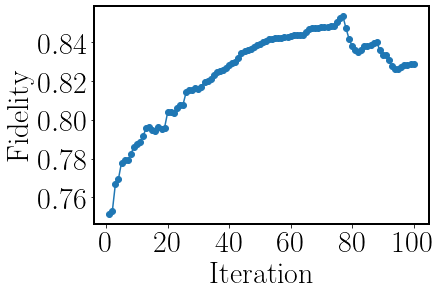

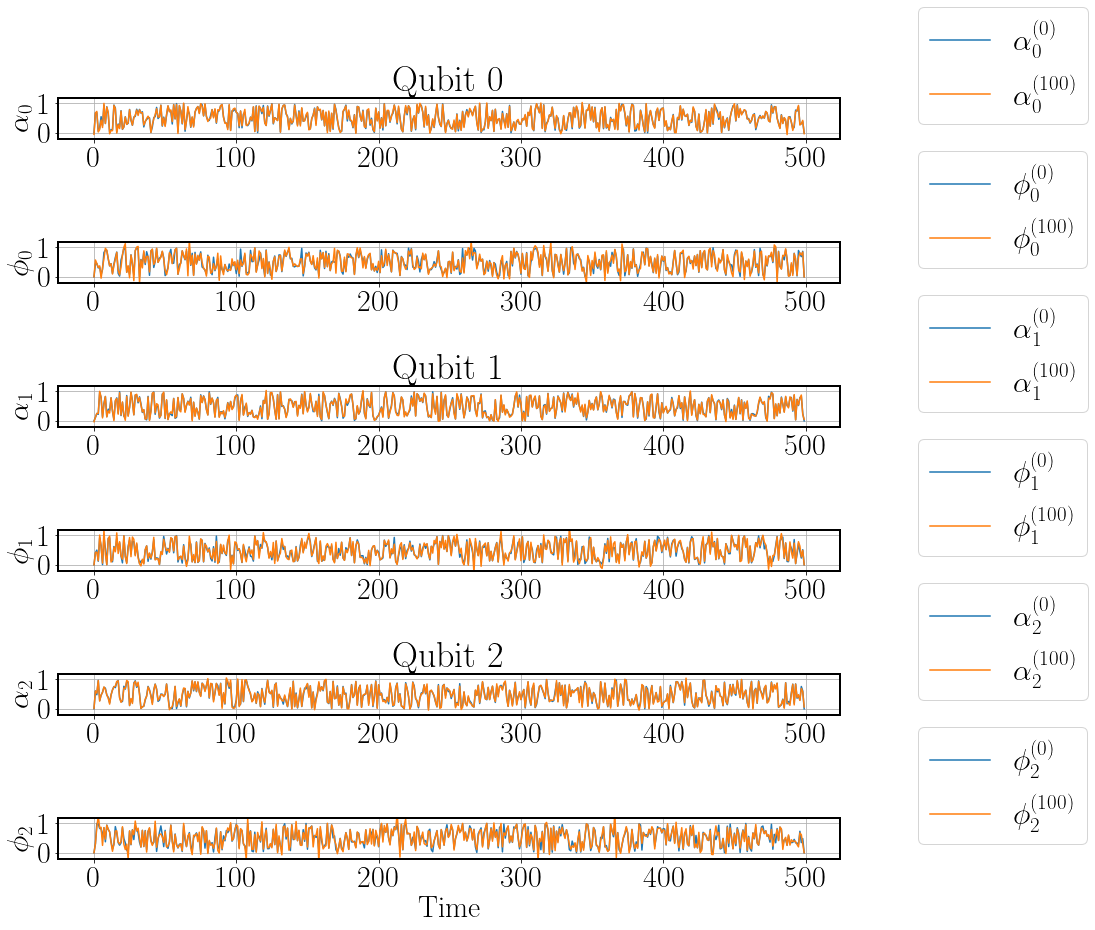

In [196]:
mplstyle = 'config/plot.mplstyle'
with matplotlib.style.context(mplstyle):

    # Fidelity
    fig,ax = plt.subplots()

    x = iterations
    y = values

    ax.plot(x,y,'o-');
    ax.set_xlabel(r'$\textrm{Iteration}$');
    ax.set_ylabel(r'$\textrm{Fidelity}$');

    # Parameters
    fig,ax = plt.subplots(q)

    for i in [0,t]:
        for j in range(q):
            x = np.arange(m)
            y = parameters[i].reshape(m,q)[:,j]

            ax[j].plot(x,y,label=r'${%s}^{(%d)}_{%s}$'%({0:r'\alpha',1:r'\phi'}[j%2],i,str(j//2) if (q>2) else ''))
            ax[j].set_ylabel(r'${%s}_{%s}$'%({0:r'\alpha',1:r'\phi'}[j%2],str(j//2) if (q>2) else ''))            
            
            ax[j].set_title(r'$\textrm{Qubit} ~ %d$'%(j//2) if (j%2==0) else None)
            ax[j].set_xlabel(r'$\textrm{Time}$' if (j==(q-1)) else None)
            ax[j].set_ylim(ymin=-0.2,ymax=1.2)
            ax[j].legend(loc=(1.1,0.35))
            ax[j].grid(visible=True,which='both')

    fig.set_size_inches(14,14)
    fig.subplots_adjust(hspace=2.5)
    fig.subplots_adjust(hspace=2.5 if (q>2) else None)
